## Step 1: Import Libraries

In [1]:
"""
EXAMPLE1: Module-20-NLP/Class-3/Activities/03-Ins_Topic_Modeling_NMF/Solved/Non-Negative-Matrix-Factorization_solution.ipynb
Non-Negative Matrix Factorization(TDIFVectorizer) to Cluster headlines 

Example2: WK21-1/ 04-Ins_HuggingFace_Tokenizers_Similarity/
similarity_measures_solution
"""
import pandas as pd
from pathlib import Path

# from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Disable truncation of long strings in pandas output
pd.set_option('display.max_colwidth', None)


## Import Data

In [7]:
from pathlib import Path
import pandas as pd

# ✅ Updated to load from Parquet
file_path = Path("./Resources/philly_reviews_without_mood.parquet")

# Load the Parquet file
customer_reviews_df = pd.read_parquet(file_path)

# Rename "text" column to "review" if needed
customer_reviews_df = customer_reviews_df.rename(columns={"text": "review"})

# Display the first few rows
display(customer_reviews_df.head())

,review_id,user_id,business_id,review,business_name,address,city,categories,friends,review_stars,...,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,YpDx1X1OvnwUgdkHeZNvWw,OfhZlqYMrCVAhM-bt_cQug,J-ciDDEdIHMcChGIyKZnOg,Beautiful clean shop with knock your socks off...,Cake Life Bake Shop,1306 Frankford Ave,Philadelphia,"Caterers, Cafes, Event Planning & Services, Fo...","[rFANUt3nNW1auqcQTILUGQ, x1_sp_rHxZtI8VLX_IF5c...",4.0,...,0,0,0,0,0,6,0,0,0,0
1,MxQpzn4DLrQ6XuhEHkVvIw,QuZKJnltihmZ8jhwfxPeJA,QWqKTWQ2OiDgo3dzNkpung,The best soon-dubu in the city! This place is...,Jong Ka Jib,6600 N 5th St,Philadelphia,"Korean, Restaurants","[KVOYtl0OfPpzRCmZNaNqNA, qO_AVSbRl0k1du46i43zd...",5.0,...,5,1,0,0,2,23,2,2,4,0
2,2fD2Do7xBjoahST3FmiwcQ,avQwKRvXc21koLCbahFEig,AY1SyySRyTnBwBdf7qfGxQ,"From the second you walk in the door, you're g...",Citi Market place,1318 Walnut St,Philadelphia,"Grocery, Vegan, Food, Vegetarian, Convenience ...","[-SlWJhzUzqUO61vJoKYbOA, GkOQYF8PlqJKMm3MPuY2E...",5.0,...,8,4,3,1,6,10,17,17,8,2
3,nDH6ctdQskr7_V_ot3_mVw,mzXDuhZBPdHfMIk1YXP0mQ,mUIBtlWNPD7sz3rGGWQ1RA,I moved from Chicago to Philadelphia over a ye...,Kanella,1001 Spruce St,Philadelphia,"Mediterranean, Food, Greek, Restaurants, Break...","[Y1dYFoFc6jLbK5VmjfZ-aQ, Ls0wyEROsq3LYptBDI5HN...",5.0,...,7,3,0,1,19,23,18,18,7,0
4,zKZAppIn3yZVp7sTw-8ZLw,au30JemWvCjjTp5vWdOLow,Gw7UW0E2BguzL9suQnwDeg,One of the best burgers in Philly!\n\nLow key ...,SPOT Gourmet Burgers,2821 W Girard Ave,Philadelphia,"Restaurants, Food, Cheesesteaks, Food Trucks, ...","[ET8n-r7glWYqZhuR6GcdNw, 5yELiLhZv8aCNI1_Qpb3k...",5.0,...,0,0,0,0,1,1,0,0,1,2


## Classify mood:


In [8]:
"""
Required library Installations::
1. transformers: Hugging Face library for state-of-the-art NLP models
2. sentence-transformers: Simplified interface for computing sentence embeddings and semantic similarity
3. pandas: Data handling and manipulation library
4. SentenceTransformer: Loads pre-trained models for sentence embeddings.
5. util: Provides similarity utilities like cosine similarity.
"""

# %pip install -q transformers sentence-transformers pandas
from sentence_transformers import SentenceTransformer, util

# Store Semantic Categories:
moods = [
    "adventurous", "comforting", "energizing", "romantic",
    "cozy", "festive", "indulgent", "refreshing"
]

"""
Use HugginFace sentence-transformers package and the 
all-MiniLM-L6-v2 model to classify review text
Initialize sentence Embedding Model with all_miniLM-L6-v2
to training and calculate the probalistic distance between
vectors to determin semantic similarity
"""
model = SentenceTransformer("all-MiniLM-L6-v2")  # lightweight and accurate

mood_embeddings = model.encode(moods, convert_to_tensor=True)

def assign_mood(text):
    """
    function classifies the mood of yelp customer review text
    """
    # Checks if the input is a non-empty string.
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "neutral"
    
    # Encodes the review text into an embedding.
    text_embedding = model.encode(text, convert_to_tensor=True)
    
    # Compares the review embedding against mood embeddings using cosine similarity
    similarity_scores = util.pytorch_cos_sim(text_embedding, mood_embeddings)
    
    # Returns the mood with the highest similarity
    best_match = similarity_scores.argmax().item()
    return moods[best_match]

#  Add the classified moods to a new column called mood
customer_reviews_df["mood"] = customer_reviews_df["review"].apply(assign_mood)

# Output the new dataset with mood labels
output_path = "./Resources/philly_reviews_with_mood.parquet"
customer_reviews_df.to_parquet(output_path, index=False)

print(f"Saved labeled file to: {output_path}")




Saved labeled file to: ./Resources/philly_reviews_with_mood.parquet


In [4]:
# Check Mood Value Counts:
mood_counts = customer_reviews_df["mood"].value_counts()
total_records_classified = customer_reviews_df["mood"].value_counts().sum()
# Print results
print("📊 Mood Classification Breakdown:\n")
print(mood_counts)
print("Total Classified Records:", total_records_classified )

# Total number of records
total_records = len(customer_reviews_df)
print(f"Total Records: {total_records}")

# Verify that all records have been classified:
if total_records_classified == total_records:
    print(f"All records have been classified")
else:
    print(f"All records have not been classified")

📊 Mood Classification Breakdown:

mood
indulgent      40395
cozy           32034
festive         7504
adventurous     3337
energizing       879
romantic         644
refreshing       375
comforting       364
Name: count, dtype: int64
Total Classified Records: 85532
Total Records: 85532
All records have been classified


In [5]:
# Loop through each unique mood and print 5 examples
for mood in customer_reviews_df["mood"].unique():
    print(f"\n===== {mood.upper()} REVIEWS =====")
    
    # Filter and get the first 5 samples
    samples = customer_reviews_df[customer_reviews_df["mood"] == mood].head(5)
    
    for i, text in enumerate(samples["review"], start=1):
        print(f"\n{i}. {text.strip()}")



===== COZY REVIEWS =====

1. I got the gyro "platter" for lunch, which was dry, uninspired, and nothing like a deconstructed gyro. Worst of all, it came with "vegetables" which looked more like poop. Tasted that way, too. There are better places in Fairmount for lunch, and they won't serve you poop, either.

2. The best soon-dubu in the city!  This place is tucked away and once you walk in, it's like you've stepped into a Korean home.  Very welcoming, warm and inviting.

It's very vegetarian friendly!  The soft tofu is stewed and put into the dol sot pots which each and every stew feels like it's custom made for you. 

You can select from beef, seafood or mixed meats (seafood & beef), mushroom, and just plain.  They can adjust the spice as needed too.  I always get the extra hot with the hot temperature, can't beat it.  The rice also comes in a dol-sot which is great if you leave it in for a while, it burns the rice into a nice crispy shell.  DROOL.

Just thinking about this place mak

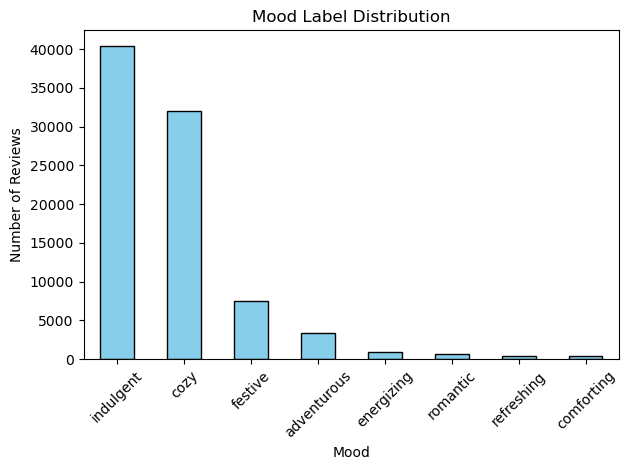

In [6]:
# Plot the mood counts
import matplotlib.pyplot as plt

mood_counts.plot(kind='bar', title='Mood Label Distribution', color='skyblue', edgecolor='black')
plt.xlabel("Mood")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
